# Model Analysis
The objective of this notebook is to develop predictive models to classify melanoma lessions in either benign or malignant. 

To evaluate the performance of each model, Train/Test split (80/20) and Cross-Validation (cv=10) will be used throughout the analysis. The nature of the project requires scoring methods different than accuracy, as mislabelling a benign melanoma is less fatal than mislabelling a malignant. For this reason, the following metrics will be used:
- Confusion Matrix, as a visual verification
- Recall, putting the enphasis on reducing False Negative

Additional metrics, such as AUC, were proposed by the Kaggle organizers. To understand the impact of our decissions, Receiver Operating Characteristic (ROC) curve will be obtained for verification purposes. 

This notebook will have the following sections:
- Data preparation
- Model selection, using three approaches: Metadata Only, Images Only, both sources
- Data optimisation, adding image augmentation techniques to minimise bias
- Model tuning, modifying architecture hyperparameters

## Import Packages

In [61]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

sys.path.append("../Melanoma/")
import data_preprocessing
import image_preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Data Preparation

In this section, tabular information is loaded and features are extracted for further postprocessing.

In [62]:
# Go to root if required
if os.getcwd().split("/")[-1] == "Explore":
    os.chdir("..")

# Define datasets locations
input_dcm_train = 'Datasets/dcm/train/'
input_dcm_filelist = os.listdir(input_dcm_train)
input_metadata_train = 'Datasets/train.csv'

# Load metadata datasets and remove NA and duplicates
md_train = pd.read_csv(input_metadata_train)                            \
    .pipe(lambda df: df.dropna(subset=["age_approx", "sex"], axis=0))   \
    .pipe(data_preprocessing.AgeOutlierAnalysis)                        \
    .pipe(data_preprocessing.RemoveDuplicateRecords)                    \
    .dropna(axis=0)                                                     \
    .set_index("image_name")                                            \
    .astype({
        "age_approx": 'float',
        "anatom_site_general_challenge": 'category',
        "diagnosis": 'category'
    })

md_train['age_approx'] = MinMaxScaler().fit_transform(md_train['age_approx'].values.reshape(-1,1))
md_train['IsMale'] = md_train.sex.apply(lambda x: 1 if x=="male" else 0)
md_train.head()

,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,IsMale
image_name,,,,,,,,
ISIC_2637011,IP_7279968,male,0.4375,head/neck,unknown,benign,0,1
ISIC_0015719,IP_3075186,female,0.4375,upper extremity,unknown,benign,0,0
ISIC_0052212,IP_2842074,female,0.5000,lower extremity,nevus,benign,0,0
ISIC_0068279,IP_6890425,female,0.4375,head/neck,unknown,benign,0,0
ISIC_0074268,IP_8723313,female,0.5625,upper extremity,unknown,benign,0,0


In [63]:
# Split dataset between features and labels
y = md_train.target
X = md_train.drop(["target", "benign_malignant", "patient_id", "sex", "diagnosis"], axis=1)
X = X.rename({'anatom_site_general_challenge': "Location"}, axis=1)
X = pd.get_dummies(X, columns=["Location"])
X = X.astype('float32')
X.head()

,age_approx,IsMale,Location_head/neck,Location_lower extremity,Location_oral/genital,Location_palms/soles,Location_torso,Location_upper extremity
image_name,,,,,,,,
ISIC_2637011,0.4375,1.0,1.0,0.0,0.0,0.0,0.0,0.0
ISIC_0015719,0.4375,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ISIC_0052212,0.5000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ISIC_0068279,0.4375,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ISIC_0074268,0.5625,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

## Model Training
Now, we will train this dataset with various models:
- KNN
- Random Forest
- XGBoost

The model performance will be measured through Cross-validation using Recall and AUC and plotting both Confussion Matrix.

In [65]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [66]:
DM_model = DummyClassifier(strategy='most_frequent')
KNN_model = KNeighborsClassifier(n_neighbors=5)
RF_model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=14)
XGB_model = XGBClassifier(n_estimators=1000, max_depth=10, random_state=14, use_label_encoder=False)

Establish the null score by using the dummy classifier

In [67]:
Null_model = cross_validate(DM_model, X_train, y_train, cv=5, scoring=["roc_auc","recall"])
Null_recall = sum(Null_model['test_recall'])/len(Null_model['test_recall'])
Null_AUC = sum(Null_model['test_roc_auc'])/len(Null_model['test_roc_auc'])

### Standard configuration

In [68]:
# Cross-Validation
cv = StratifiedKFold(n_splits=5)

# KNN Variables
knn_conf_matrix = np.zeros((2,2))
knn_recall = []
knn_auc = []

# Random Forest Variables
rf_conf_matrix = np.zeros((2,2))
rf_recall = []
rf_auc = []

# XGBoost Variables
xg_conf_matrix = np.zeros((2,2))
xg_recall = []
xg_auc = []

for idx_train, idx_test in cv.split(X_train, y_train):
    # Obtain the split
    X, y = X_train.values[idx_train], y_train.values[idx_train]

    # Train both models 
    KNN_model.fit(X, y)
    RF_model.fit(X, y)
    XGB_model.fit(X, y)

    # Obtain prediction dataset
    X, y = X_train.values[idx_test], y_train.values[idx_test]

    # Predict both models
    KNN_pred = KNN_model.predict(X)
    RF_pred = RF_model.predict(X)
    XGB_pred = XGB_model.predict(X)

    # Store Confusion Matrix + Recall Score + AUC
    knn_conf_matrix += confusion_matrix(y, KNN_pred)
    rf_conf_matrix += confusion_matrix(y, RF_pred)
    xg_conf_matrix += confusion_matrix(y, XGB_pred)
    knn_recall.append(recall_score(y, KNN_pred))
    rf_recall.append(recall_score(y, RF_pred))
    xg_recall.append(recall_score(y, XGB_pred))
    knn_auc.append(roc_auc_score(y, KNN_pred))
    rf_auc.append(roc_auc_score(y, RF_pred))
    xg_auc.append(roc_auc_score(y, XGB_pred))

[18:05:02] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:05:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:05:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

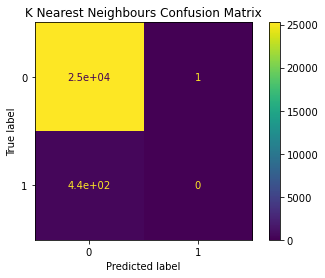

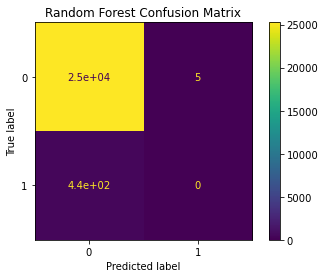

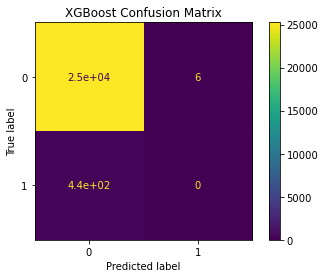

--------------
Recall Results
--------------
Null Hypothesis -> 0.0
KNN           -> 0.0
Random Forest -> 0.0
XGBoost       -> 0.0
--------------

--------------
AUC Results
--------------
Null Hypothesis -> 0.5
KNN           -> 0.4999802097763705
Random Forest -> 0.49990104104724287
XGBoost       -> 0.49988124690630853
--------------


In [69]:
# Analyse the results
# Recall
knn_recall_av = sum(knn_recall)/len(knn_recall)
rf_recall_av = sum(rf_recall)/len(rf_recall)
xg_recall_av = sum(xg_recall)/len(xg_recall)
# AUC 
knn_auc_av = sum(knn_auc)/len(knn_auc)
rf_auc_av = sum(rf_auc)/len(rf_auc)
xg_auc_av = sum(xg_auc)/len(xg_auc)

# Display results
# Confusion Matrix
disp = ConfusionMatrixDisplay(knn_conf_matrix)
disp.plot()
plt.title("K Nearest Neighbours Confusion Matrix")
plt.show()

disp = ConfusionMatrixDisplay(rf_conf_matrix)
disp.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

disp = ConfusionMatrixDisplay(xg_conf_matrix)
disp.plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

print("--------------")
print("Recall Results")
print("--------------")
print("Null Hypothesis -> " + str(Null_recall))
print("KNN           -> " + str(knn_recall_av))
print("Random Forest -> " + str(rf_recall_av))
print("XGBoost       -> " + str(xg_recall_av))
print("--------------")
print("")
print("--------------")
print("AUC Results")
print("--------------")
print("Null Hypothesis -> " + str(Null_AUC))
print("KNN           -> " + str(knn_auc_av))
print("Random Forest -> " + str(rf_auc_av))
print("XGBoost       -> " + str(xg_auc_av))
print("--------------")


It is clear that these models are highly influenced by the bias in the dataset.
Two alternative approaches will be explored:
- Tune XGBoost hyperparameters
- Try a simple NN

### Tune hyperparameters

Use different combination of hyperparameters to find best model performance

In [71]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

XGB_model = XGBClassifier(random_state=14, verbosity=0, use_label_encoder=False)
params = {
    "n_estimators": [10, 100, 1000],
    "learning_rate": [0.01, 0.1, 0.3, 0.5],
    "max_depth": [5, 10, 20, 50]
}
Grid_CV = GridSearchCV(XGB_model, param_grid=params, scoring='recall', n_jobs=-1, verbose=1)
Grid_CV.fit(X_train, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=14,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use_label_encoder=Fa

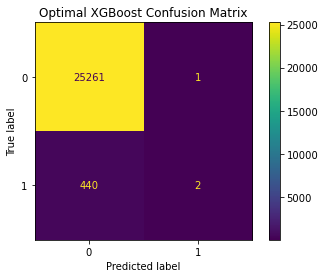

The best parameters found are -> {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}
The best recall achieved are -> 0.0022727272727272726


In [78]:
y_pred = Grid_CV.predict(X_train)
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Optimal XGBoost Confusion Matrix")
plt.show()


print("The best parameters found are -> " + str(Grid_CV.best_params_))
print("The best recall achieved are -> " + str(Grid_CV.best_score_))


The improvement obtained is marginal, obtaining two classification over the training dataset.
It is clear this is not the way forwards.

### Create simple Neural Network

Create simple 1-hidden stage Neural Network, using two hidden layers with 16 neurons each

In [80]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

print("Tensorflow version " + str(tf.__version__))

Tensorflow version 2.6.0


In [81]:
SimpleNN = Sequential()
SimpleNN.add(Dense(16, activation='relu', input_shape=[len(X_train.columns)]))
SimpleNN.add(Dense(16, activation='relu'))
SimpleNN.add(Dense(1, activation='sigmoid'))
SimpleNN.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_28 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 17        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


In [82]:
SimpleNN.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['AUC'])
SimpleNN.fit(X_train, y_train, epochs=100, callbacks=EarlyStopping(monitor='auc', patience=5))

Epoch 1/100
804/804 [==============================] - 1s 611us/step - loss: 0.1700 - auc: 0.4935
Epoch 2/100
804/804 [==============================] - 1s 623us/step - loss: 0.0888 - auc: 0.4979
Epoch 3/100
804/804 [==============================] - 0s 609us/step - loss: 0.0878 - auc: 0.5072
Epoch 4/100
804/804 [==============================] - 1s 756us/step - loss: 0.0871 - auc: 0.5076
Epoch 5/100
804/804 [==============================] - 1s 750us/step - loss: 0.0866 - auc: 0.5357
Epoch 6/100
804/804 [==============================] - 1s 723us/step - loss: 0.0862 - auc: 0.5515


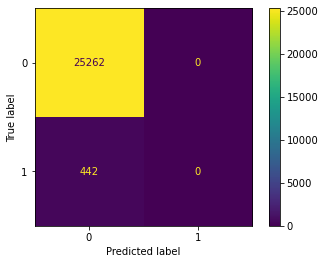

In [83]:
y_pred = SimpleNN.predict(X_train)
cm = tf.math.confusion_matrix(y_train, y_pred).numpy()
disp = ConfusionMatrixDisplay(cm)
disp.plot()

The bias on this model towards the minority class is even higher. I will move now towards the use of medical images.